In [133]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append("..")
from partition import *
from constants import *

In [134]:
# complete

def phi(ionized_ion, T):
    """
    Calculates the phi function from Gray's eqs 1.20-1.21
    
    T - is the temperature in K
    ionized_ion - is the name of the lower ionization state
    """
    
    theta = 5040/T
    if ionized_ion=='H-':
        u1 = partition('H', T)
        u0 = partition(ionized_ion, T)
        xi = 0.754195 # eV
    else:
        u1 = partition(ionized_ion+'+', T)
        u0 = partition(ionized_ion, T) 
        ionization_file = pd.read_csv('../aux_files/nist_ioniz.txt', delim_whitespace=True, header=None)
        ionization_file.columns = ['Z', 'name', 'mass', 'ioniz_e']
        row = ionization_file[ionization_file['name']==ionized_ion]
        xi = row['ioniz_e'].values[0]
    
    return 1.2020e9*u1/u0*theta**(-5/2)*10**(-theta*xi)
    

In [135]:
phi('H', 8000)

5.17058483070319

In [136]:
# completed
def kappa_Hminus_bf(Pe, T, wave):
    """
    Following equation 8.11-12 in Gray
    wave in angstroms
    T in kelvin
    Pe in cgs? dynes/cm^2
    """
    a0,a1,a2,a3,a4,a5,a6 = [1.99654, -1.18267e-5, 2.64243e-6, -4.40524e-10, 3.23992e-14, -1.39568e-18, 2.78701e-23]
    alpha_bf = a0 + a1*wave + a2*wave**2 + a3*wave**3 + a4*wave**4 + a5*wave**5 + a6*wave**6
    theta = 5040/T
    return 4.158e-10*alpha_bf*1e18*Pe*theta**(5/2)*10**(0.754*theta)

In [137]:
# completed
def kappa_Hminus_ff(Pe, T, wave):
    """
    Following equation 8.13 in Gray
    """
    f0 = -2.2763-1.6850*np.log10(wave)+0.76661*(np.log10(wave))**2-0.053346*(np.log10(wave))**3
    f1 = 15.2827-9.2846*np.log10(wave)+1.99381*(np.log10(wave))**2-0.142631*(np.log10(wave))**3
    f2 = -197.789+190.266*np.log10(wave)-67.9775*(np.log10(wave))**2+10.6913*(np.log10(wave))**3-0.625151*(np.log10(wave))**4
    theta = 5040/T
    return 1e-26*Pe*10**(f0+f1*np.log10(theta)+f2*(np.log10(theta))**2) 

In [138]:
def g_bf(n, T, wave):
    """
    equation 8.6 in gray
    """
    theta = 5040/T
    xi = 1.2398e4/wave
    return 1-(0.3456)/(wave*1.0968e-3)**(1/3)*(wave*1.0968e-3/(n**2)-1/2)

In [139]:
def kappa_H_bf(Pe, T, wave):
    """
    Using equations 8.4, 8.5, 8.8
    """
    # find n0
    n0 = int(round(np.sqrt(13.6*EV_TO_ERG/(PLANCK_ERG*SPEEDOFLIGHT/(wave*10**-8)))))+1

    theta = 5040/T
    n_array = np.array([n0, n0+1, n0+2])
    alpha0 = 1.0449e-26
    I = 13.6    # eV
    xi_array = I*(1-1/(n_array)**2)
    g_array = np.array([g_bf(i, T, wave) for i in n_array])
    summation = sum(g_array/(n_array**3)*10**(-theta*xi_array))
    xi3 = I*(1-1/(n0+3)**2) 
    
    return alpha0*wave**3*(summation+(np.log10(np.e)/(2*theta*I))*(10**(-xi3*theta)-10**(-I*theta)))


In [140]:
# completed
def kappa_H_ff(Pe, T, wave):
    """
    Using equations 8.6, 8.10
    """
    R = 1.0968e-3  # inverse Angstroms
    theta = 5040/T
    g_ff = 1+(0.3456)/(wave*R)**(1/3)*(np.log10(np.e)/(theta*1.2398e4/wave)+0.5)
    alpha0 = 1.0449e-26
    I = PLANCK_ERG*SPEEDOFLIGHT*1.0968e5 # R
    return alpha0*wave**3*g_ff*np.log10(np.e)/(2*theta*I)*10**(-theta*I)

In [141]:
def kappa_e():
    return None

In [203]:
def kappa(Pe, T, wave):
    """
    equation 8.18
    """
    theta=5040/T
    return ((kappa_H_bf(Pe, T, wave)+kappa_H_ff(Pe, T, wave)+kappa_Hminus_bf(Pe, T, wave))*(1-10**(-1.2398e4/wave*theta))
            +kappa_Hminus_ff(Pe, T, wave))*1/(1+phi('H', T)/Pe)


worked with Macy and Brianna  
ask Jason what he wants for the write up  
ask Jason whats wrong  
plot individual contributions 

In [204]:
kappa(100, 8000, 10000)

1175717176110.6099

In [205]:
wave_array = np.linspace(3000, 20000, 50)

In [206]:
opacity_a = [kappa(10**1.08, 5143, i) for i in wave_array]

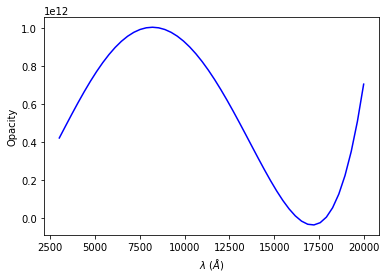

In [207]:
plt.plot(wave_array, opacity_a, 'b-', label='Figure 8.5a')
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel('Opacity')
plt.show()

In [208]:
# b
opacity_b =[kappa(10**1.77, 6429, i) for i in wave_array]

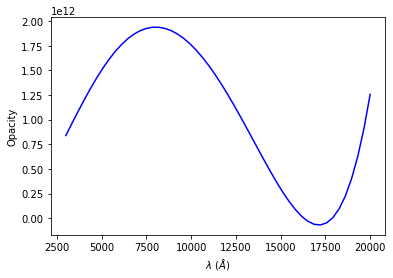

In [209]:
plt.plot(wave_array, opacity_b, 'b-', label='Figure 8.5b')
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel('Opacity')
plt.show()

In [210]:
# c
opacity_c =[kappa(10**2.5, 7715, i) for i in wave_array]

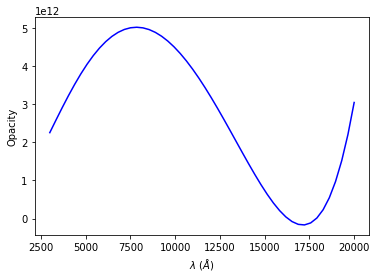

In [211]:
plt.plot(wave_array, opacity_c, 'b-', label='Figure 8.5c')
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel('Opacity')
plt.show()